In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean

In [2]:
clusters = pd.read_csv('clusters.csv', index_col = 'artist')
clusters.head()

,tsne_0,tsne_1,cluster,cluster_name,followers
artist,,,,,
Travis Scott,-49.622486,-63.165020,0,Hip hop & rap,7705985
Martin Garrix,23.056034,46.405690,1,EDM & house,12574151
Los Fabulosos Cadillacs,-27.807325,33.983185,2-0,Argentinian rock,1672897
Brockhampton,-33.395466,-67.094890,0,Hip hop & rap,1186410
DUKI,84.602455,-40.784866,3,Argentinian trap,2715207


In [3]:
cluster_followers = clusters.groupby('cluster_name')['followers'].sum()
clusters['cluster_followers'] = clusters['cluster_name'].map(cluster_followers.to_dict())
clusters['weight'] = clusters['followers'] / clusters['cluster_followers']
clusters.head()

,tsne_0,tsne_1,cluster,cluster_name,followers,cluster_followers,weight
artist,,,,,,,
Travis Scott,-49.622486,-63.165020,0,Hip hop & rap,7705985,11014805,0.699602
Martin Garrix,23.056034,46.405690,1,EDM & house,12574151,37888307,0.331874
Los Fabulosos Cadillacs,-27.807325,33.983185,2-0,Argentinian rock,1672897,2482014,0.674008
Brockhampton,-33.395466,-67.094890,0,Hip hop & rap,1186410,11014805,0.107710
DUKI,84.602455,-40.784866,3,Argentinian trap,2715207,5079022,0.534592


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
cluster_centroids = clusters.groupby('cluster_name')[['tsne_0', 'tsne_1']].mean()
cluster_centroids

,tsne_0,tsne_1
cluster_name,,
Argentinian indie,-77.929432,19.052341
Argentinian pop,-52.877103,74.021420
Argentinian rock,-39.010427,42.015199
Argentinian trap,90.884187,-30.202852
Art pop & R&B,60.218677,19.109616
EDM & house,33.756525,54.836116
Hip hop & rap,-41.519409,-65.712097
International indie & rock,-1.587642,-27.362592
International pop,42.345227,-7.598888


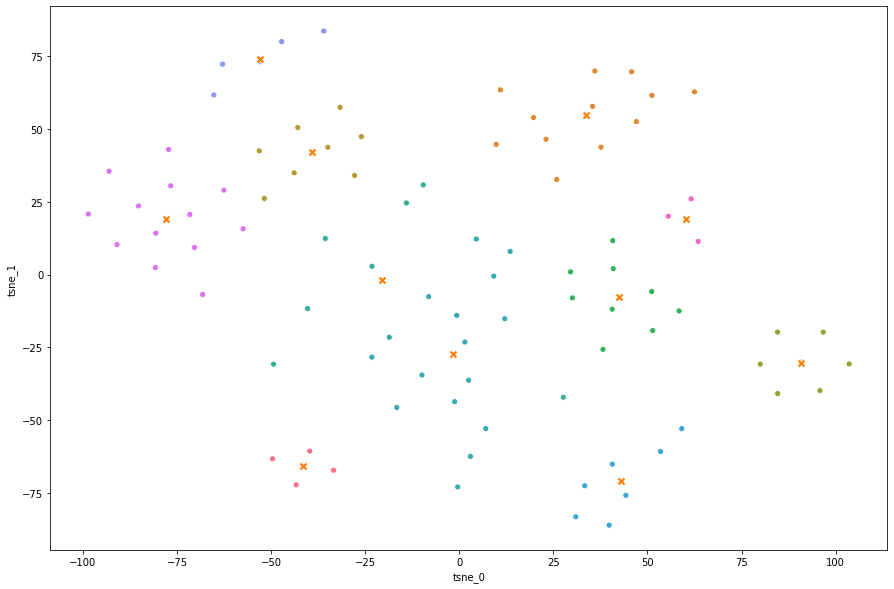

In [6]:
# sin pesos
plt.figure(figsize=(15,10))
sns.scatterplot(x='tsne_0', y='tsne_1', data=clusters, hue='cluster_name', legend=False)
sns.scatterplot(x='tsne_0', y='tsne_1', data=cluster_centroids, marker='X', s=75, legend=False);

In [7]:
cluster_centroids = clusters.groupby('cluster_name').apply(lambda x: np.average(x.tsne_0, weights=x.weight))
cluster_centroids = pd.concat([cluster_centroids, clusters.groupby('cluster_name').apply(lambda x: np.average(x.tsne_1, weights=x.weight))],
                              axis=1)
cluster_centroids.columns = ['tsne_0', 'tsne_1']
cluster_centroids

,tsne_0,tsne_1
cluster_name,,
Argentinian indie,-69.431438,21.030936
Argentinian pop,-47.506736,77.361236
Argentinian rock,-31.014930,36.950956
Argentinian trap,86.034017,-35.481313
Art pop & R&B,60.223004,17.694987
EDM & house,24.138138,41.212343
Hip hop & rap,-46.332805,-64.247461
International indie & rock,-0.881426,-43.087440
International pop,44.987376,-3.960067


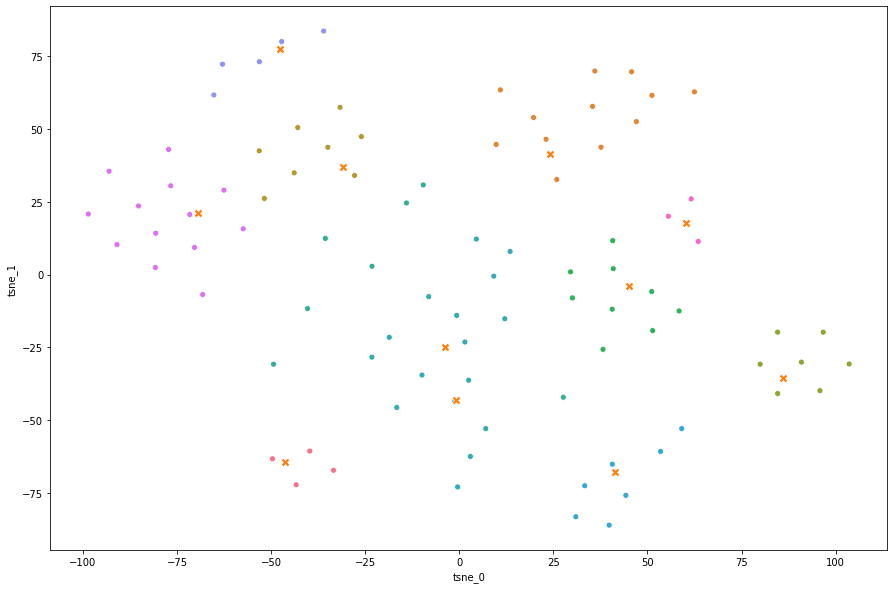

In [8]:
# con pesos
plt.figure(figsize=(15,10))
sns.scatterplot(x='tsne_0', y='tsne_1', data=clusters, hue='cluster_name', legend=False)
sns.scatterplot(x='tsne_0', y='tsne_1', data=cluster_centroids, marker='X', s=75, legend=False);

In [9]:
grid = pd.read_csv('horarios.csv')
grid['choice'] = np.nan
grid

,Day,Main stage 1,Main stage 2,Alternative,Perry’s,choice
0,1,Cimafunk,NaN,Alejo y Valentin,NaN,NaN
1,1,NaN,Fuego,NaN,Axel Fiks,NaN
2,1,Maye,NaN,Lucia Tacchetti,NaN,NaN
3,1,NaN,J mena,NaN,DJ Sky,NaN
4,1,A Day to Remember,NaN,Feli Colina,Nathy Peluso,NaN
5,1,NaN,La Delio Valdez,NaN,NaN,NaN
6,1,WOS,NaN,King Princess,Boombox Cartel,NaN
7,1,NaN,Rita Ora,Louta,Dani,NaN
8,1,Yungblud,NaN,NaN,Kaydy Cain,NaN
9,1,NaN,DUKI,Two Feet,Bizarrap,NaN


In [10]:
def check_artist_name(artist):
    if artist not in clusters.index:
        raise ValueError('Artist not found ', artist)
    return True

In [11]:
def closest_to_centroids(options, randomness=0):
    '''
    Receives a list of options and calculates pairwise distances between those options
    and the centroids of the clusters corresponding to the chosen bands,
    and returns the option closest to any centroid.
    If randomness=1, the function calculates pairwise distances between the options
    and the user centroid, and returns the option closest to the user centroid.
    '''
    
    distances = []
    artists = []
    
    if randomness==0:
        for opt in options:
            for cluster in chosen_clusters.index:
                u = clusters.loc[opt, ['tsne_0', 'tsne_1']]
                v = cluster_centroids.loc[cluster]
                distances.append(euclidean(u, v))
                artists.append(opt)
        return artists[np.argmin(distances)]
    
    elif randomness==1:
        user_centroid = clusters.loc[chosen_artists, ['tsne_0', 'tsne_1']].mean()
        for opt in options:
            u = clusters.loc[opt, ['tsne_0', 'tsne_1']]
            distances.append(euclidean(u, user_centroid))
            artists.append(opt)
        return artists[np.argmin(distances)]

In [12]:
def solve_tie(options, verbose=False, randomness=0):
    '''
    Solves a tie between options that are equally likely to be chosen based on randomness level.
    '''
    
    if randomness == 0 or randomness == 1:
        if verbose:
            print('\tVoting based on chosen clusters...')
        
        # if there are options in the same clusters as the chosen artists' clusters,
        # all the chosen artists vote for their cluster
        votes = pd.merge(clusters.loc[options, 'cluster_name'],
                         chosen_clusters, 
                         left_on='cluster_name', 
                         right_index=True,
                         ).sort_values('cluster_weight', ascending=False)

        # if there's a winner
        if len(votes) > 0:
            # if there's only one winner
            if len(votes) == 1:
                if verbose:
                    print('\tThere is a winner.')
                # return the winner
                return votes.index[0]
            # if there's a tie between the winners
            if votes['cluster_weight'].iloc[0] == votes['cluster_weight'].iloc[1]:
                if verbose:
                    print('\tThere is a tie. Choosing closest distance.')
                # return closest to centroid between winners
                winners = votes.index[votes['cluster_weight'] == votes.iloc[0, -1]]#.to_list()
                return closest_to_centroids(winners, randomness=randomness)

        # if there's no winner, return closest to centroid between options
        if verbose:
            print('\tThere is no winner. Choosing closest distance.')
        return closest_to_centroids(options, randomness=randomness)
        
    else:
        if verbose:
            print('Choosing randomly.')
        return np.random.choice(options)

In [13]:
def fill_slot(slot, verbose=False, randomness=0):
    '''
    Fills grid slots based on chosen artists and desired randomness level.
    '''
    
    if verbose:
        print('Filling slot ', slot)
    options = grid.iloc[slot,1:-1]
    
    if verbose:
        print('Choosing between ', list(options))
    
    # if only one option is in the chosen bands
    if options.isin(chosen_artists).sum() == 1:
        # fill with chosen artist
        chosen = options[options.isin(chosen_artists)].values[0]
        if verbose:
            print(chosen, ' is among the chosen artists.')
        return chosen
    
    # if there are no chosen artists between the options
    elif options.isin(chosen_artists).sum() == 0:
        if verbose:
            print('There are no chosen artists among the options. Breaking tie...')
        # break tie between all options
        chosen = solve_tie(options.dropna(), verbose=verbose, randomness=randomness)
        if verbose:
            print('\tTie broken. Winner: ', chosen)
        return chosen
    
    # if there are more than one chosen artists between the options
    else:
        # solve tie between chosen options
        if verbose:
            print('There are more than one artist among the chosen ones. Breaking tie...')
        chosen = solve_tie(options[options.isin(chosen_artists)], verbose=verbose, randomness=randomness)
        if verbose:
            print('\tTie broken. Winner: ', chosen)
        return chosen

Prueba 1: tres artistas, dos clusters

In [14]:
chosen_artists = ['La Delio Valdez', 'Los Fabulosos Cadillacs', 'Guns N’ Roses']

In [15]:
chosen_clusters = clusters.loc[chosen_artists, 'cluster_name'].value_counts().rename('cluster_weight')
chosen_clusters

Argentinian rock              2
International indie & rock    1
Name: cluster_weight, dtype: int64

In [16]:
for artist in chosen_artists:
    check_artist_name(artist)

In [17]:
randomness = 0
for index in range(len(grid)):
    grid.iloc[index, -1] = fill_slot(index, verbose=False, randomness=randomness)

In [18]:
grid.loc[grid['Day'] == 3]

,Day,Main stage 1,Main stage 2,Alternative,Perry’s,choice
27,3,NaN,El Buen Salvaje,Elsa y Elmar,NaN,Elsa y Elmar
28,3,Natalie Perez,NaN,NaN,NaN,Natalie Perez
29,3,NaN,Miranda Johansen,NaN,NaN,Miranda Johansen
30,3,Emilia,NaN,The Hu,Reydel,The Hu
31,3,NaN,Airbag,NaN,DABOW,Airbag
32,3,Idles,NaN,Masego,NaN,Idles
33,3,NaN,Lauv,NaN,Florian,Lauv
34,3,Perry Farrell’s Kind Heaven Orchestra,NaN,Pabllo Vittar,Goldfish,Perry Farrell’s Kind Heaven Orchestra
35,3,NaN,Rex Orange County,NaN,YSY A,Rex Orange County
36,3,Cage the Elephant,NaN,MIKA,Rezz,Cage the Elephant


In [19]:
randomness = 1
for index in range(len(grid)):
    grid.iloc[index, -1] = fill_slot(index, verbose=False, randomness=randomness)

In [20]:
grid.loc[grid['Day'] == 3]

,Day,Main stage 1,Main stage 2,Alternative,Perry’s,choice
27,3,NaN,El Buen Salvaje,Elsa y Elmar,NaN,Elsa y Elmar
28,3,Natalie Perez,NaN,NaN,NaN,Natalie Perez
29,3,NaN,Miranda Johansen,NaN,NaN,Miranda Johansen
30,3,Emilia,NaN,The Hu,Reydel,The Hu
31,3,NaN,Airbag,NaN,DABOW,Airbag
32,3,Idles,NaN,Masego,NaN,Idles
33,3,NaN,Lauv,NaN,Florian,Florian
34,3,Perry Farrell’s Kind Heaven Orchestra,NaN,Pabllo Vittar,Goldfish,Perry Farrell’s Kind Heaven Orchestra
35,3,NaN,Rex Orange County,NaN,YSY A,Rex Orange County
36,3,Cage the Elephant,NaN,MIKA,Rezz,Cage the Elephant


In [21]:
randomness = 2
for index in range(len(grid)):
    grid.iloc[index, -1] = fill_slot(index, verbose=False, randomness=randomness)

In [22]:
grid.loc[grid['Day'] == 3]

,Day,Main stage 1,Main stage 2,Alternative,Perry’s,choice
27,3,NaN,El Buen Salvaje,Elsa y Elmar,NaN,El Buen Salvaje
28,3,Natalie Perez,NaN,NaN,NaN,Natalie Perez
29,3,NaN,Miranda Johansen,NaN,NaN,Miranda Johansen
30,3,Emilia,NaN,The Hu,Reydel,Emilia
31,3,NaN,Airbag,NaN,DABOW,Airbag
32,3,Idles,NaN,Masego,NaN,Masego
33,3,NaN,Lauv,NaN,Florian,Lauv
34,3,Perry Farrell’s Kind Heaven Orchestra,NaN,Pabllo Vittar,Goldfish,Pabllo Vittar
35,3,NaN,Rex Orange County,NaN,YSY A,Rex Orange County
36,3,Cage the Elephant,NaN,MIKA,Rezz,Rezz


Prueba 2: tres artistas, tres clusters

In [23]:
chosen_artists = ['Trueno', 'Denzel Curry', 'Armin Van Buuren']

In [24]:
chosen_clusters = clusters.loc[chosen_artists, 'cluster_name'].value_counts().rename('cluster_weight')
chosen_clusters

Argentinian trap    1
Hip hop & rap       1
EDM & house         1
Name: cluster_weight, dtype: int64

In [25]:
for index in range(len(grid)):
    grid.iloc[index, -1] = fill_slot(index, verbose=False)

In [26]:
grid

,Day,Main stage 1,Main stage 2,Alternative,Perry’s,choice
0,1,Cimafunk,NaN,Alejo y Valentin,NaN,Cimafunk
1,1,NaN,Fuego,NaN,Axel Fiks,Fuego
2,1,Maye,NaN,Lucia Tacchetti,NaN,Maye
3,1,NaN,J mena,NaN,DJ Sky,DJ Sky
4,1,A Day to Remember,NaN,Feli Colina,Nathy Peluso,A Day to Remember
5,1,NaN,La Delio Valdez,NaN,NaN,La Delio Valdez
6,1,WOS,NaN,King Princess,Boombox Cartel,WOS
7,1,NaN,Rita Ora,Louta,Dani,Dani
8,1,Yungblud,NaN,NaN,Kaydy Cain,Yungblud
9,1,NaN,DUKI,Two Feet,Bizarrap,DUKI


Prueba 3: cinco artistas, tres clusters

In [27]:
chosen_artists = ['J mena', 'Lana del Rey', 'Gwen Stefani', 'Emilia', 'Emmanuel Horvilleur']

In [28]:
chosen_clusters = clusters.loc[chosen_artists, 'cluster_name'].value_counts().rename('cluster_weight')
chosen_clusters

Argentinian pop      2
International pop    2
Argentinian rock     1
Name: cluster_weight, dtype: int64

In [29]:
for index in range(len(grid)):
    grid.iloc[index, -1] = fill_slot(index, verbose=False)

In [30]:
grid

,Day,Main stage 1,Main stage 2,Alternative,Perry’s,choice
0,1,Cimafunk,NaN,Alejo y Valentin,NaN,Cimafunk
1,1,NaN,Fuego,NaN,Axel Fiks,Axel Fiks
2,1,Maye,NaN,Lucia Tacchetti,NaN,Maye
3,1,NaN,J mena,NaN,DJ Sky,J mena
4,1,A Day to Remember,NaN,Feli Colina,Nathy Peluso,A Day to Remember
5,1,NaN,La Delio Valdez,NaN,NaN,La Delio Valdez
6,1,WOS,NaN,King Princess,Boombox Cartel,King Princess
7,1,NaN,Rita Ora,Louta,Dani,Rita Ora
8,1,Yungblud,NaN,NaN,Kaydy Cain,Yungblud
9,1,NaN,DUKI,Two Feet,Bizarrap,Bizarrap


Prueba 4: rock indie

In [31]:
chosen_artists = ['The Strokes', 'Cage the Elephant', 'El Mató a un Policía Motorizado', 'DUKI']

In [32]:
chosen_clusters = clusters.loc[chosen_artists, 'cluster_name'].value_counts().rename('cluster_weight')
chosen_clusters

International indie & rock    2
Argentinian trap              1
Argentinian rock              1
Name: cluster_weight, dtype: int64

In [33]:
for index in range(len(grid)):
    grid.iloc[index, -1] = fill_slot(index, verbose=False)

In [34]:
grid

,Day,Main stage 1,Main stage 2,Alternative,Perry’s,choice
0,1,Cimafunk,NaN,Alejo y Valentin,NaN,Cimafunk
1,1,NaN,Fuego,NaN,Axel Fiks,Fuego
2,1,Maye,NaN,Lucia Tacchetti,NaN,Maye
3,1,NaN,J mena,NaN,DJ Sky,DJ Sky
4,1,A Day to Remember,NaN,Feli Colina,Nathy Peluso,Nathy Peluso
5,1,NaN,La Delio Valdez,NaN,NaN,La Delio Valdez
6,1,WOS,NaN,King Princess,Boombox Cartel,WOS
7,1,NaN,Rita Ora,Louta,Dani,Dani
8,1,Yungblud,NaN,NaN,Kaydy Cain,Yungblud
9,1,NaN,DUKI,Two Feet,Bizarrap,DUKI


Prueba 5: electrónica

In [35]:
chosen_artists = ['Martin Garrix', 'Armin Van Buuren', 'Nathy Peluso']

In [36]:
chosen_clusters = clusters.loc[chosen_artists, 'cluster_name'].value_counts().rename('cluster_weight')
chosen_clusters

EDM & house    2
Latin trap     1
Name: cluster_weight, dtype: int64

In [37]:
for index in range(len(grid)):
    grid.iloc[index, -1] = fill_slot(index, verbose=False)

In [38]:
grid

,Day,Main stage 1,Main stage 2,Alternative,Perry’s,choice
0,1,Cimafunk,NaN,Alejo y Valentin,NaN,Cimafunk
1,1,NaN,Fuego,NaN,Axel Fiks,Fuego
2,1,Maye,NaN,Lucia Tacchetti,NaN,Maye
3,1,NaN,J mena,NaN,DJ Sky,DJ Sky
4,1,A Day to Remember,NaN,Feli Colina,Nathy Peluso,Nathy Peluso
5,1,NaN,La Delio Valdez,NaN,NaN,La Delio Valdez
6,1,WOS,NaN,King Princess,Boombox Cartel,Boombox Cartel
7,1,NaN,Rita Ora,Louta,Dani,Rita Ora
8,1,Yungblud,NaN,NaN,Kaydy Cain,Kaydy Cain
9,1,NaN,DUKI,Two Feet,Bizarrap,DUKI
